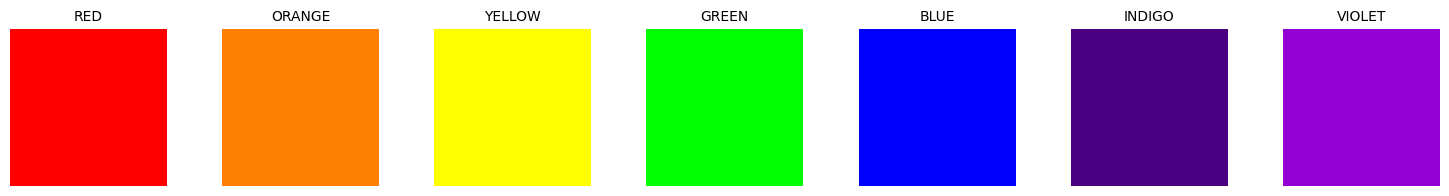

In [7]:
#이제 아래의 데이터 적재를 위해 기존팔레트로 다시 변경
import matplotlib.pyplot as plt
from PIL import Image

np.random.seed(42)  # 난수 생성기의 초기값 설정 (재현성 보장)

# 기존 팔레트 정의
RAINBOW_COLORS = [
    (255, 0, 0),    # 빨강
    (255, 127, 0),  # 주황
    (255, 255, 0),  # 노랑
    (0, 255, 0),    # 초록
    (0, 0, 255),    # 파랑
    (75, 0, 130),   # 남색 (인디고)
    (148, 0, 211)   # 보라
]

RAINBOW_NAMES = [
    'RED', 'ORANGE', 'YELLOW', 'GREEN', 'BLUE', 'INDIGO', 'VIOLET'
]

# 1x7 그리드로 색상 표시
fig, axes = plt.subplots(1, 7, figsize=(15, 2))

for col in range(7):  # 0부터 6까지 반복
    fg_color = RAINBOW_COLORS[col]  # 팔레트에서 해당 색상 선택
    fg_label = RAINBOW_NAMES[col]  # 색상 이름

    # 빈 이미지를 만들어 색칠
    blank_image = Image.new("RGB", (28, 28), color=fg_color)

    axes[col].imshow(blank_image)
    axes[col].axis('off')  # 축을 비활성화합니다.

    # 타이틀에 색상 이름을 추가합니다.
    axes[col].set_title(f'{fg_label}', fontsize=10)

plt.tight_layout()
plt.show()

In [8]:
import torch
from torchvision import datasets, transforms
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

#모델 학습을 위한 데이터 적재
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

X_color = []
y_bg = []
y_fg = []
y_digit = []

def get_random_rainbow_color():
    """무지개 팔레트에서 임의의 색상을 선택합니다."""
    # return tuple(np.random.randint(0, 256, size=3))
    idx = np.random.randint(0, len(RAINBOW_COLORS))
    return RAINBOW_COLORS[idx], RAINBOW_NAMES[idx]

def colorize_digit(digit_image, fg_color, bg_color):
    """숫자 이미지에 전경(fg)과 배경(bg) 색상을 적용합니다."""
    digit = digit_image.convert('L')  # 이미지를 그레이스케일로 변환합니다.
    colored_digit = ImageOps.colorize(digit, black=bg_color, white=fg_color).convert('RGB')
    return colored_digit

for i in range(len(mnist)):
    image, label = mnist[i]
    pil_image = transforms.ToPILImage()(image)

    # 전경과 배경 색상을 무작위로 선택합니다.
    fg_color, fg_label = get_random_rainbow_color()
    bg_color, bg_label = get_random_rainbow_color()

    # 전경과 배경 색상이 같지 않도록 보장합니다.
    while bg_color == fg_color:
        bg_color, bg_label = get_random_rainbow_color()

    # 전경 및 배경 색상이 적용된 숫자 이미지를 생성합니다.
    colored_digit = colorize_digit(pil_image, fg_color, bg_color)

    # 결과 이미지를 numpy 배열로 변환하고 리스트에 추가합니다.
    X_color.append(np.array(colored_digit))
    y_digit.append(label)
    y_fg.append(fg_label)
    y_bg.append(bg_label)

#리스트를 Numpy로 변환
X_color = np.array(X_color)
y_digit = np.array(y_digit)
y_fg = np.array(y_fg)
y_bg = np.array(y_bg)

# 데이터 형태를 확인합니다.
print(f"X_color.shape: {X_color.shape}")
print(f"y_digit.shape: {y_digit.shape}")
print(f"y_fg.shape: {y_fg.shape}")
print(f"y_bg.shape: {y_bg.shape}")

X_color.shape: (60000, 28, 28, 3)
y_digit.shape: (60000,)
y_fg.shape: (60000,)
y_bg.shape: (60000,)


In [9]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# X_color를 (60000, 28, 28, 3)에서 (60000, 2352)로 변환 (flatten)
X_color = np.array(X_color).reshape(-1, 28 * 28 * 3)

# 변환된 X_color_flat의 shape 확인
print(X_color.shape)  # (60000, 2352)

# X_color와 y_fg, y_bg, y_digit에 대한 훈련/검증 세트를 나누기
X_train, X_test = X_color[:50000], X_color[50000:]
y_train_fg, y_test_fg = y_fg[:50000], y_fg[50000:]
y_train_bg, y_test_bg = y_bg[:50000], y_bg[50000:]
y_train_digit, y_test_digit = y_digit[:50000], y_digit[50000:]

# X_train, y_train_fg, y_train_bg, y_train_digit을 한 번에 훈련/검증 세트로 나누기
X_train_split, X_val_split, y_train_fg_split, y_val_fg_split, y_train_bg_split, y_val_bg_split, y_train_digit_split, y_val_digit_split = train_test_split(
    X_train, y_train_fg, y_train_bg, y_train_digit, test_size=0.1, random_state=42
)

(60000, 2352)


In [12]:
# RandomForest 모델
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_model_fg = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_bg = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_digit = RandomForestClassifier(n_estimators=100, random_state=42)

# 모델 학습
start_time_fg = time.time()
rf_model_fg.fit(X_train_split, y_train_fg_split)
end_time_fg = time.time()

start_time_bg = time.time()
rf_model_bg.fit(X_train_split, y_train_bg_split)
end_time_bg = time.time()

start_time_digit = time.time()
rf_model_digit.fit(X_train_split, y_train_digit_split)
end_time_digit = time.time()

# 검증 데이터로 예측
start_time_fg_val = time.time()
y_val_fg_pred = rf_model_fg.predict(X_val_split)
end_time_fg_val = time.time()

start_time_bg_val = time.time()
y_val_bg_pred = rf_model_bg.predict(X_val_split)
end_time_bg_val = time.time()

start_time_digit_val = time.time()
y_val_digit_pred = rf_model_digit.predict(X_val_split)
end_time_digit_val = time.time()

training_time_fg = end_time_fg - start_time_fg
training_time_bg = end_time_bg - start_time_bg
training_time_digit = end_time_digit - start_time_digit

training_time_fg_val = end_time_fg_val - start_time_fg_val
training_time_bg_val = end_time_bg_val - start_time_bg_val
training_time_digit_val = end_time_digit_val - start_time_digit_val


print(f"Random Forest 전경 색상(fg) 정확도: {accuracy_fg_rf:.4f}")
print(f"Random Forest 전경 색상(fg) 학습 시간: {training_time_fg:.2f} 초")
print(f"Random Forest Validation 전경 색상(fg) 예측 시간: {training_time_fg_val:.2f} 초")

print(f"Random Forest 배경 색상(bg) 정확도: {accuracy_bg_rf:.4f}")
print(f"Random Forest 배경 색상(bg) 학습 시간: {training_time_bg:.2f} 초")
print(f"Random Forest Validation 배경 색상(bg) 예측 시간: {training_time_bg_val:.2f} 초")

print(f"Random Forest 숫자(digit) 정확도: {accuracy_digit_rf:.4f}")
print(f"Random Forest 숫자(digit) 학습 시간: {training_time_digit:.2f} 초")
print(f"Random Forest Validation 숫자(digit) 예측 시간: {training_time_digit_val:.2f} 초")

Random Forest 전경 색상(fg) 정확도: 1.0000
Random Forest 전경 색상(fg) 학습 시간: 41.31 초
Random Forest Validation 전경 색상(fg) 예측 시간: 0.11 초
Random Forest 배경 색상(bg) 정확도: 1.0000
Random Forest 배경 색상(bg) 학습 시간: 12.55 초
Random Forest Validation 배경 색상(bg) 예측 시간: 0.04 초
Random Forest 숫자(digit) 정확도: 0.9318
Random Forest 숫자(digit) 학습 시간: 65.82 초
Random Forest Validation 숫자(digit) 예측 시간: 0.22 초


In [13]:
# Min - Max 이후

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_color_flattened = X_color.reshape(-1, 28 * 28 * 3)
X_color_scaled = scaler.fit_transform(X_color_flattened)

In [15]:
X_train, X_test = X_color_scaled[:50000], X_color_scaled[50000:]
y_train_fg, y_test_fg = y_fg[:50000], y_fg[50000:]
y_train_bg, y_test_bg = y_bg[:50000], y_bg[50000:]
y_train_digit, y_test_digit = y_digit[:50000], y_digit[50000:]

X_train_split, X_val_split, y_train_fg_split, y_val_fg_split, y_train_bg_split, y_val_bg_split, y_train_digit_split, y_val_digit_split = train_test_split(
    X_train, y_train_fg, y_train_bg, y_train_digit, test_size=0.1, random_state=42
)

In [16]:
# RandomForest 모델

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_model_fg = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_bg = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_digit = RandomForestClassifier(n_estimators=100, random_state=42)

# 모델 학습
start_time_fg = time.time()
rf_model_fg.fit(X_train_split, y_train_fg_split)
end_time_fg = time.time()

start_time_bg = time.time()
rf_model_bg.fit(X_train_split, y_train_bg_split)
end_time_bg = time.time()

start_time_digit = time.time()
rf_model_digit.fit(X_train_split, y_train_digit_split)
end_time_digit = time.time()

# 검증 데이터로 예측
start_time_fg_val = time.time()
y_val_fg_pred = rf_model_fg.predict(X_val_split)
end_time_fg_val = time.time()

start_time_bg_val = time.time()
y_val_bg_pred = rf_model_bg.predict(X_val_split)
end_time_bg_val = time.time()

start_time_digit_val = time.time()
y_val_digit_pred = rf_model_digit.predict(X_val_split)
end_time_digit_val = time.time()

training_time_fg = end_time_fg - start_time_fg
training_time_bg = end_time_bg - start_time_bg
training_time_digit = end_time_digit - start_time_digit

training_time_fg_val = end_time_fg_val - start_time_fg_val
training_time_bg_val = end_time_bg_val - start_time_bg_val
training_time_digit_val = end_time_digit_val - start_time_digit_val

print(f"Min-Max Scaling")
print(f"Random Forest 전경 색상(fg) 정확도: {accuracy_fg_rf:.4f}")
print(f"Random Forest 전경 색상(fg) 학습 시간: {training_time_fg:.2f} 초")
print(f"Random Forest Validation 전경 색상(fg) 예측 시간: {training_time_fg_val:.2f} 초")

print(f"Random Forest 배경 색상(bg) 정확도: {accuracy_bg_rf:.4f}")
print(f"Random Forest 배경 색상(bg) 학습 시간: {training_time_bg:.2f} 초")
print(f"Random Forest Validation 배경 색상(bg) 예측 시간: {training_time_bg_val:.2f} 초")

print(f"Random Forest 숫자(digit) 정확도: {accuracy_digit_rf:.4f}")
print(f"Random Forest 숫자(digit) 학습 시간: {training_time_digit:.2f} 초")
print(f"Random Forest Validation 숫자(digit) 예측 시간: {training_time_digit_val:.2f} 초")

Min-Max Scaling
Random Forest 전경 색상(fg) 정확도: 1.0000
Random Forest 전경 색상(fg) 학습 시간: 39.85 초
Random Forest Validation 전경 색상(fg) 예측 시간: 0.13 초
Random Forest 배경 색상(bg) 정확도: 1.0000
Random Forest 배경 색상(bg) 학습 시간: 12.59 초
Random Forest Validation 배경 색상(bg) 예측 시간: 0.06 초
Random Forest 숫자(digit) 정확도: 0.9318
Random Forest 숫자(digit) 학습 시간: 66.39 초
Random Forest Validation 숫자(digit) 예측 시간: 0.23 초
